# Generate a single field primary beam

[Colab Link](https://colab.research.google.com/github/casangi/astroviper/blob/main/docs/core_tutorials/imaging/imaging_utils/cube_single_field_primary_beam.ipynb)



This notebook domonstrates how to generate a primary beam image with provided some imaging parameters

---

## Assumptions/Current limitation


- Currently only support ALMA telescopes (ALMA 12m and ACA 7m)
- Only airy disk model with a blockage is supported
- Following parameters are used :
  * Effective dish diameter: ALMA 10.7m,  ACA 6.7m    
  * Blockage diameter: ALMA 0.75m, ACA 0.75m

---


## API

In [1]:
from astroviper.core.imaging.imaging_utils.make_primary_beam import cube_single_field_primary_beam

In [2]:
cube_single_field_primary_beam?

Signature:
cube_single_field_primary_beam(
    im_params,
    telescope,
    model='casa_airy_disk',
)
Docstring:
Generate a primary beam image for a single field in a measurement set.

Parameters:
im_params : dict
    Imaging parameters: must include
    'cell_size': angular size of a pixel 2d tuple (rad, rad),
    'image_size': int 2d tuple (nx, ny),
    'frequency_coords': list of frequencies in Hz,
    'polarization': list of Stokes parameters,
    'image_center': image center pixel coordinates int 2d tuple (x, y),
    'phase_center': phase reference center (RA, Dec) in radians,
    'time_coords': list of time coordinates in seconds.

telescope : str
    The name of the telescope (e.g., 'ALMA', 'ACA').

model : str, optional
    The primary beam model to use. Currently only one of the two versions of
    Airy disk model defined in make_pb_symmetric. Default is 'casa_airy_disk'.

Returns:
pb_image : xarray.Dataset
    The generated primary beam image as an XRADIO image with a data v

## Install AstroVIPER

Skip this cell if you don't want to install the latest version of AstroVIPER.

In [ ]:
from importlib.metadata import version
import os

try:
    os.system("pip install --upgrade astroviper")

    import astroviper

    print("Using astroviper version", version("astroviper"))

except ImportError as exc:
    print(f"Could not import astroviper: {exc}")

## Install additional modules needed for this demo

In [4]:
from xradio.image import open_image, load_image
from toolviper.utils.data import download, update
import numpy as np

## Example 1
Generate ALMA (12m) primary beam and compare with the PB image made by CASA

### Download Data

In [ ]:
# download the data from CASA Google Drive
!pip install gdown

import gdown
gdown.download(id="1_UzXgQeE0glsjiGcc8NzcoZp_DpswnoK", quiet=True)
!unzip -o 3c286_Band6_5chans_lsrk_robust_0.5_niter_99.pb.zip

In [6]:
# Load CASA pb image to be used for comparison
casapb_im = open_image(
        "3c286_Band6_5chans_lsrk_robust_0.5_niter_99.pb",
)
casapb_im

Successful readonly open of default-locked table 3c286_Band6_5chans_lsrk_robust_0.5_niter_99.pb: 1 columns, 1 rows


<xarray.Dataset> Size: 7MB
Dimensions:            (time: 1, frequency: 5, polarization: 4, l: 250, m: 250)
Coordinates:
  * time               (time) float64 8B 5.684e+04
  * frequency          (frequency) float64 40B 2.398e+11 2.399e+11 ... 2.403e+11
  * polarization       (polarization) <U1 16B 'I' 'Q' 'U' 'V'
    velocity           (frequency) float64 40B 2.216e+05 6.54e+04 ... -4.03e+05
  * l                  (l) float64 2kB 6.06e-05 6.012e-05 ... -6.012e-05
  * m                  (m) float64 2kB -6.06e-05 -6.012e-05 ... 6.012e-05
    right_ascension    (l, m) float64 500kB 3.539 3.539 3.539 ... 3.539 3.539
    declination        (l, m) float64 500kB 0.5324 0.5324 ... 0.5325 0.5325
Data variables:
    PRIMARY_BEAM       (time, frequency, polarization, l, m) float32 5MB dask.array<chunksize=(1, 5, 4, 250, 250), meta=np.ndarray>
    MASK_PRIMARY_BEAM  (time, frequency, polarization, l, m) bool 1MB dask.array<chunksize=(1, 5, 4, 250, 250), meta=np.ndarray>
Attributes:
    coordinate_system_info:  {'reference_direction': {'attrs': {'frame': 'fk5...
    type:                    image
    data_groups:             {'base': {'mask_primary_beam': 'MASK_PRIMARY_BEA...

### Construct imaging parameters based on the CASA PB image

In [7]:
# Extract some image parameters 
phase_center = casapb_im.attrs['coordinate_system_info']['reference_direction']['data']
image_shape = casapb_im.PRIMARY_BEAM.shape
cell_size = [(casapb_im.l[1]-casapb_im.l[0]).values.item(), (casapb_im.m[1]-casapb_im.m[0]).values.item()]
frequency_coords = casapb_im.frequency.values.tolist()
polarization_coords = casapb_im.polarization.values.tolist()
time_coords = casapb_im.time.values.tolist()

In [8]:
# Store in imaging parameter dictionary 
im_params={}
 
im_params['image_size'] = image_shape[-2:]
im_params['cell_size'] = tuple(cell_size)
im_params['image_center'] = tuple([int(im_params['image_size'][0]/2), int(im_params['image_size'][1]/2)])
im_params['phase_center'] = tuple(phase_center)
im_params['frequency_coords'] = frequency_coords
im_params['polarization'] = polarization_coords
im_params['time_coords'] = time_coords

### Generate PB image

In [9]:
pb_image = cube_single_field_primary_beam(im_params, telescope='ALMA')

In [10]:
# select single timestamp, polarization, frequency (use channel 0 data)
data_sel = {"time": [0], "polarization": [0], "frequency": [4]}

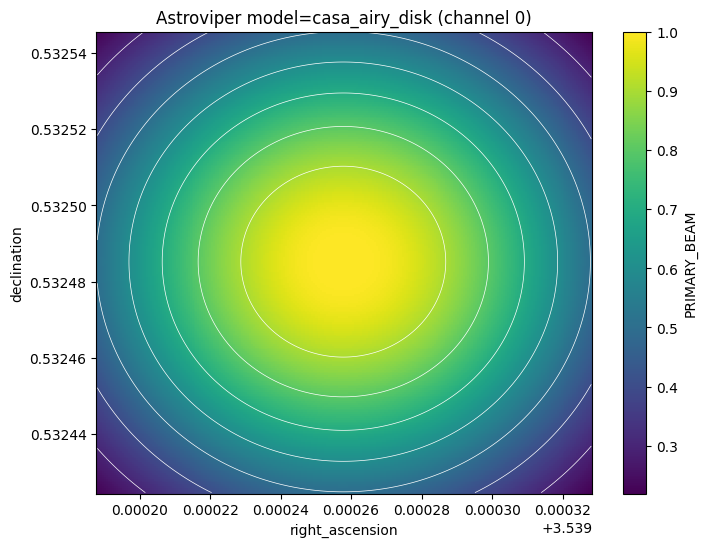

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
im = pb_image["PRIMARY_BEAM"].isel(data_sel).squeeze().plot.pcolormesh(x='right_ascension', y='declination')
ct = pb_image["PRIMARY_BEAM"].isel(data_sel).squeeze().plot.contour(levels=10, colors='white', linewidths=0.5, x='right_ascension', y='declination')
plt.title('Astroviper model=casa_airy_disk (channel 0)')
plt.show()

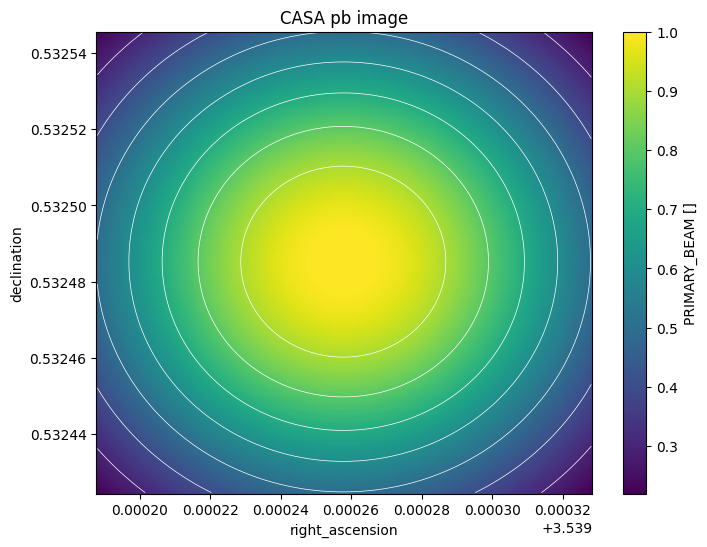

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))


im = casapb_im["PRIMARY_BEAM"].isel(data_sel).squeeze().plot.pcolormesh(x='right_ascension', y='declination')
ct = casapb_im["PRIMARY_BEAM"].isel(data_sel).squeeze().plot.contour(levels=10, colors='white', linewidths=0.5, x='right_ascension', y='declination')
plt.title('CASA pb image')
plt.show()

In [13]:
diff_ch0_im = pb_image["PRIMARY_BEAM"].isel(data_sel).data.squeeze() - casapb_im["PRIMARY_BEAM"].isel(data_sel).data.squeeze()


In [14]:
rel_diff = abs(diff_ch0_im.compute())/casapb_im["PRIMARY_BEAM"].isel(data_sel).data.squeeze().compute()

Text(0.5, 1.0, 'Fractional differences between CASA PB image and Astroviper image')

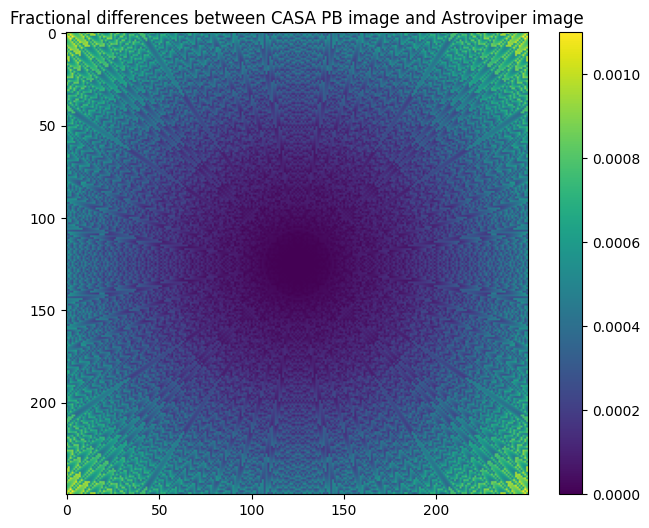

In [15]:
plt.figure(figsize=(8,6))
plt.imshow(rel_diff)
plt.colorbar()
plt.title('Fractional differences between CASA PB image and Astroviper image')

(array([10781., 13716., 14276., 10612.,  7292.,  3166.,  1557.,   772.,
          272.,    56.]),
 array([0.        , 0.00010996, 0.00021992, 0.00032988, 0.00043984,
        0.0005498 , 0.00065976, 0.00076972, 0.00087968, 0.00098964,
        0.0010996 ]),
 <BarContainer object of 10 artists>)

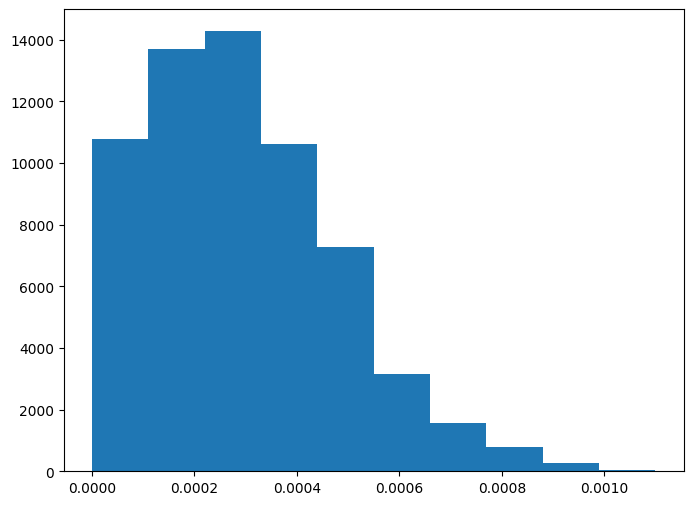

In [16]:
# Plot histogram of fractional differences
plt.figure(figsize=(8,6))
flatten_data = rel_diff.ravel()
plt.hist(flatten_data)

### Airy disk model based on the equation from the Wikipedia 
model = 'airy_model' uses model based on the equation for Obecured Airy Pattern in https://en.wikipedia.org/wiki/Airy_disk

In [17]:
pb_image2 = cube_single_field_primary_beam(im_params, telescope='ALMA', model='airy_model')

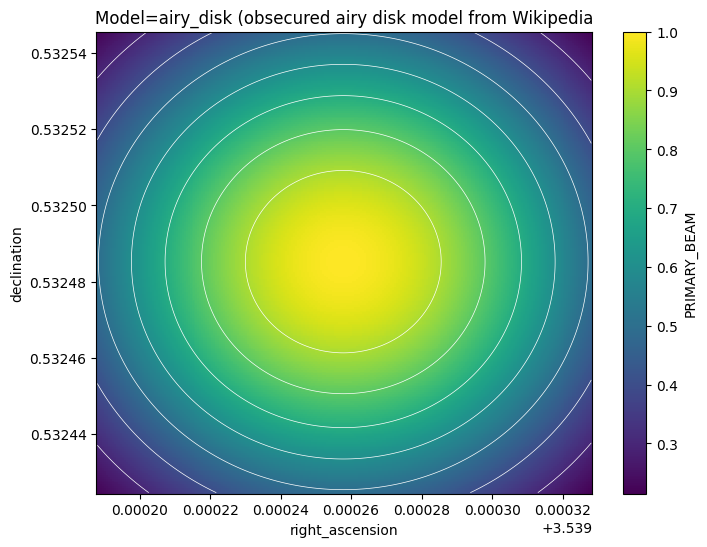

In [18]:
plt.figure(figsize=(8,6))
im = pb_image2["PRIMARY_BEAM"].isel(data_sel).squeeze().plot.pcolormesh(x='right_ascension', y='declination')
ct = pb_image2["PRIMARY_BEAM"].isel(data_sel).squeeze().plot.contour(levels=10, colors='white', linewidths=0.5, x='right_ascension', y='declination')
plt.title('Model=airy_disk (obsecured airy disk model from Wikipedia')
plt.show()

In [19]:
diff_ch0_im2 = pb_image2["PRIMARY_BEAM"].isel(data_sel).data.squeeze() - casapb_im["PRIMARY_BEAM"].isel(data_sel).data.squeeze()
rel_diff2 = abs(diff_ch0_im2.compute())/casapb_im["PRIMARY_BEAM"].isel(data_sel).data.squeeze().compute()

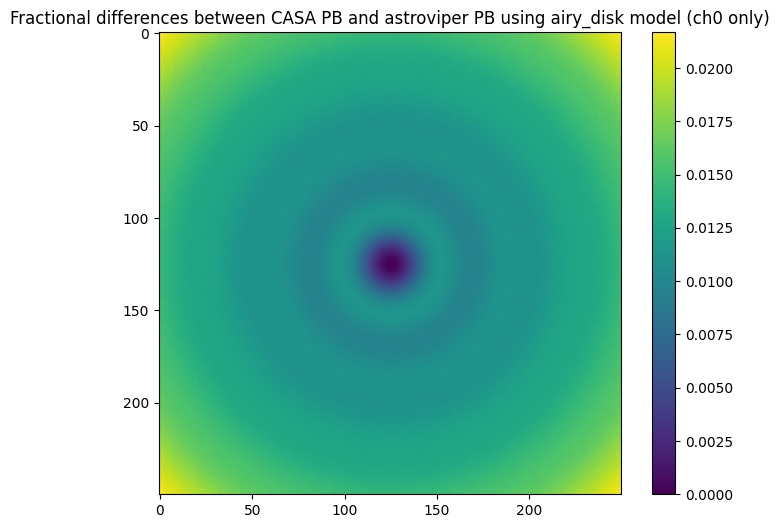

In [20]:
plt.figure(figsize=(8,6))
plt.imshow(rel_diff2)
plt.colorbar()
plt.title('Fractional differences between CASA PB and astroviper PB using airy_disk model (ch0 only)')
plt.show()

## Example 2

Generate ACA 7-m PB image


In [21]:
acapb_image = cube_single_field_primary_beam(im_params, telescope='ACA')

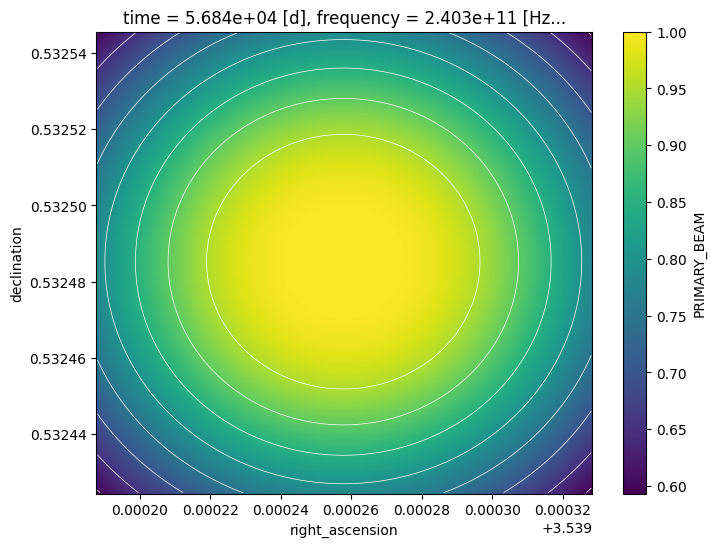

In [22]:
plt.figure(figsize=(8,6))
im = acapb_image["PRIMARY_BEAM"].isel(data_sel).squeeze().plot.pcolormesh(x='right_ascension', y='declination')
ct = acapb_image["PRIMARY_BEAM"].isel(data_sel).squeeze().plot.contour(levels=10, colors='white', linewidths=0.5, x='right_ascension', y='declination')
plt.show()